<a href="https://colab.research.google.com/github/andresdp/things-blockchain/blob/main/sim_blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Trabajo Práctico: Simulación de una Blockchain simple**
*Andres Diaz Pace*

---
### **Merkle Tree**

La primera parte es la implementación de un Arbol de Merkle para poder registrar en cada bloque (de la blockchain) un grupo de transacciones. Cada transaccion se ve como un registro de tipo JSON.

La implementación del Arbol de Merkle se basó en la biblioteca [anytree](https://github.com/c0fec0de/anytree), para facilitar temás comunes de manejo y visualización de un árbol binario. *Nota*: No se consideró el balanceo del árbol.

In [1]:
!pip install anytree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 117 kB/s 


In [2]:
from anytree import NodeMixin, RenderTree
from anytree.exporter import DotExporter
from IPython.display import Image
from hashlib import sha256

# The main class for our Merkle Tree, which inherits from a base class (NodeMixin) from the anytree library
class MerkleTree(NodeMixin):

  # Constructor. The 'name' parameter refers to the contents of the node.
  # In our case, the content is the hash (of the transactions) of the node
  def __init__(self, name, parent=None, children=None):
    self.value = name
    if self.value is not None:
      self.name = MerkleTree._hash(self.value)
    else:
      self.name = None
    self.parent = parent
    if children:
      self.children = children
  
  # Build a binary tree with the (whole) list of transactions for a block
  def build(self, transactions):
      nodes = []
      self.transactions = []
      for tx in transactions:
        n = MerkleTree(tx)
        nodes.append(n)
    
      while len(nodes) > 1:
        new_level = []
        for i in range(0,len(nodes),2):
            node1 = nodes[i]
            if i+1 < len(nodes):
                node2 = nodes[i+1]
            else:
                new_level.append(nodes[i])
                break
            # Each (internal) node computes a has being equal to the sum of the hashes of its children
            fake_value = node1.name + node2.name
            parent = MerkleTree(fake_value, children=[node1, node2])
            new_level.append(parent)
        nodes = new_level 
    
      return nodes[0] # The root of the tree is returned
  
  # Utility function (class method) to compute a SHA256 of any input
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()

  # Access to the root hash (content of root node)
  def get_root_hash(self):
      return self.name

  # Utility function (class method) used for pretty printing of the tree
  def _nodenamefunc(node):
      if node.is_leaf:
        return "tx: " + node.value + "\n" + node.name 
      else:
        return node.name 

  # Utility function (class method) used for pretty printing of the tree
  def _nodeattrfunc(node):
      if node.is_leaf:
        return "shape=box" 
      else:
        return "shape=ellipse" 
  
  # It returns the leaves of the tree
  # If 'hashes' is True the transaction hashes are return. 
  # Otherwise, the real transactions are returned
  def get_transactions(self, hashes=True):
      if hashes:
        return ([node.name for node in self.leaves])
      else:
        return ([node.value for node in self.leaves])

  # It prints the tree to console (both hashes and transactions)
  def print(self):
      for pre, _, node in RenderTree(self):
        if node.is_leaf:
          print(pre, node.name, "(tx:", node.value,")")
        else:
          print(pre, node.name)
  
  # It renders the tree in a graphical format (both hashes and transactions)
  def show(self, img='mt.png'):
      de = DotExporter(self, nodeattrfunc=MerkleTree._nodeattrfunc,
              nodenamefunc=MerkleTree._nodenamefunc).to_picture(img)
      return Image(img)

---

In [3]:
# Test: Creation of a tree with 3 transactions
mt = MerkleTree(None)
mt = mt.build(['aa', 'bb', 'cc'])
mt.print()

 603228d3f0f74f6679ecc0e928a47ca7d486954d448bcfd7e156f3221095e971
├──  857b3347845d4297a11b88ed6e315e94773004f61ed1b027c583a5186e3579ca
│   ├──  961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506 (tx: aa )
│   └──  3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf (tx: bb )
└──  355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce (tx: cc )


In [4]:
# Test: Printing the hashes of the transactions (leaves)
# If parameter 'hashes" is False, then the real values of the transactions are printed
mt.get_transactions(hashes=True)

['961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506',
 '3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf',
 '355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce']

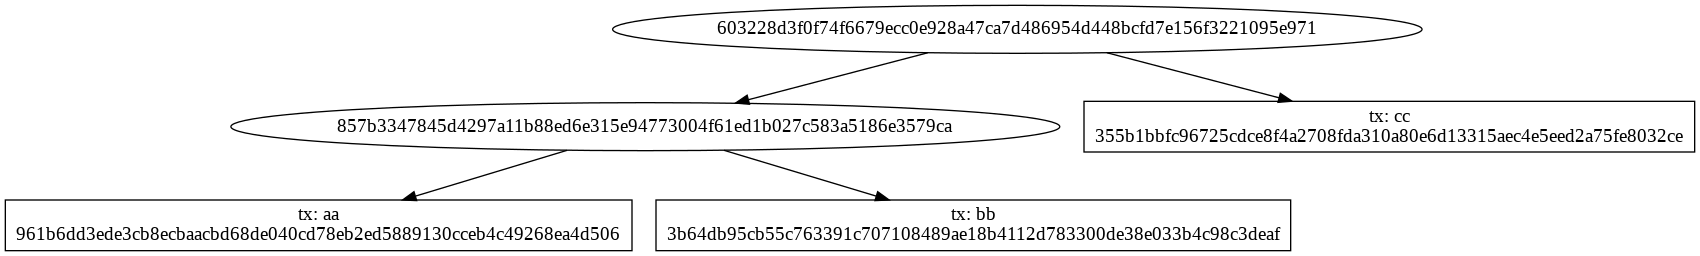

In [5]:
# Test: A graphical representation of the tree
mt.show()

---
### **Blockchain**

La segunda parte es la implementación de la blockchain en si, que integra: el árbol de Merkle, la prueba de trabajo, y la estructura de bloques y transacciones.
*  Se asume que existe un único minero, al cual el sistema le paga por cada bloque de transacciones que registra. 
*  Las transacciones que arriba se dejan "pendientes", hasta que se completa la cantidad requerida por un bloque, y recién ahí se registran.
*  Las transacciones pueden fallar si son incorrectas, o involucran wallets inexistentes, o bien no hay saldo para realizar la transaccion.
*  Cada bloque posee internamente un arbol de Merkle que codifica sus transacciones

In [6]:
from random import randint
from hashlib import sha256
from datetime import datetime
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import random
import json

class Blockchain:

  # Constructor
  def __init__(self, name, difficulty=2, tx_per_block=2, initial_money=50):
    self.name = name
    self.difficulty = difficulty # default value for proof of work
    self.transactions_per_block = tx_per_block # default value for transactions per block
    self.reward_money = initial_money # default value to issue by the system (to miners)

    # A list of the valid wallets along with their balance
    # Note: the balance of each wallet is kept for usability, but the blockchain
    # always relies on its ledger of transactions (and not on the wallets)
    self.wallets = dict()

    # The hashes of the blocks are kept separate from the blocks themselves
    self.hashed_blocks = []
    self.pending_transactions = [] # Transactions not committed yet to blocks
    self.blocks = [] # The list of blocks (without their hashes)

    # Initialization of the list with block 0 (genesis)
    self._add_genesis_block()

  # It returns the current balance of a wallet. 
  # The balance is reconstructed based on previous transactions in the blocks
  # Parameter 'transactions' might contain pending transactions (yet not committed to blocks)
  # that need to be considered in the reconstruction process
  def get_state(self, wallet, transactions=[]):    
    state = 0
    pos = None
    # Look for the last registered transactions related to the wallet
    for i in range(0, len(self.blocks)):
      bk = self.blocks[i]
      for tx in bk['transactions']:
        if tx['source'] == wallet:
          state = tx['state_source']
          pos = i
        if tx['target'] == wallet:
          state = tx['state_target']
          pos= i
    
    # In case there might be additional pending transactions affecting the wallet
    for tx in transactions:
      #print("Additional transaction:", json.dumps(tx))
      if tx['source'] == wallet:
        state = tx['state_source']
        pos = -1
      if tx['target'] == wallet:
        state = tx['state_target']
        pos= -1

    # Value 'pos' is the latest block with a transaction affecting the balance (state) of the wallet
    # Value 'state' is the actual balance of the wallet
    return pos, state

  # Utility function to create a transaction record (as a dictionary)
  # The dictionary includes: source and target wallets, and ammount of the transaction
  # To facilitate the reconstruction process, each transaction keeps track of the state
  # of the 2 wallets AFTER the transaction was executed
  # The parameters 'source' and 'target' should refer to existing wallets in the blockchain
  def _create_transaction(self, source, target, amount, state_source, state_target):
    formatted_tx = dict()
    formatted_tx['source'] = source
    formatted_tx['target'] = target
    formatted_tx['amount'] = amount

    if source  in self.wallets.keys():
      formatted_tx['state_source'] = state_source #self.wallets[source]
    else:
      formatted_tx['state_source'] = -1

    if target in self.wallets.keys():
      formatted_tx['state_target'] = state_target #self.wallets[target]
    else:
      formatted_tx['state_target'] = -1
      
    return formatted_tx
  
  # It effectively transfers an amount of money from a 'source' wallet to a 'target' wallet
  # It the source wallet doesn't have enough money, the transfer is not executed
  # Before executing the transaction, the state (balance) of both wallets is reconstructed
  # from the history of the blocks
  # Parameter 'valid_transactions' might include transactions to be committed in the current block (which are not yet part of the chain)
  def _execute_money_transfer(self, source, target, amount, valid_transactions):
    # The return values are a pair indicating whether the transanction succeeded,
    # along with the transaction just created
    
    # Both wallets must exist in the blockchain
    if (source != 'system') and (source not in self.wallets.keys()):
      return False, None
    if target not in self.wallets.keys():
      return False, None

    # Reconstruction of the balance of both wallets
    _, state_source_wallet = self.get_state(source, valid_transactions)
    _, state_target_wallet = self.get_state(target, valid_transactions)

    # The transfer operation itself (from system to miner)
    # Name 'system' is a special sender to issue money in the blockchain
    # If the source is 'system', the the target should be a miner that gets paid for committing a block
    if source == 'system': 
      self.wallets[target] += amount # The transaction is reflected on the wallet for usability
      state_target_wallet += amount
      tx = self._create_transaction(source, target, amount, state_source_wallet, state_target_wallet)
      #print(json.dumps(tx)
      return True, tx
    
    # The transfer operation itself (from any source to any target wallets) 
    # The source wallet should have enough balance for the withdrawal
    if state_source_wallet >= amount: 
      self.wallets[source] -= amount # The transaction is reflected on the wallet for usability
      self.wallets[target] += amount # The transaction is reflected on the wallet for usability
      state_source_wallet -= amount
      state_target_wallet += amount
      tx = self._create_transaction(source, target, amount, state_source_wallet, state_target_wallet)
      #print(json.dumps(tx)
      return True, tx
    else:
      return False, None

  # It parses the incoming transaction (as a string) and tries to execute it.
  # Param 'block_transactions' might include additional transactions to be commited in the current block
  # The return values are a pair indicating whether the transaction succeeded (to execute), 
  # along with the transaction itself - formatted as a JSON dictionary.
  def _execute_transaction(self, transaction, block_transactions=[]):
    list_args = transaction.split(' ')
    if 'sends' in list_args:
      # Parse the transaction and extract its arguments 
      source = list_args[0]
      target = list_args[4]
      amount = list_args[2][1:]
      # Execute the transaction
      ok, tx = self._execute_money_transfer(source, target, int(amount), valid_transactions=block_transactions)
      print("Executing transaction...", "wallet-"+source, "-->", "wallet-"+target, ":", "$",amount, "[", ok,"]")
      return ok, tx
    else:
      print("Unknown transaction:", transaction)
      return False, None

  # It creates a new wallet with an empty balance.
  # Note: if the wallet already exists, then its state is overriden to 0
  def add_wallet(self, user):
    if (user != 'system') and (user != 'miner'): # These are special wallets handled by the blockchain
      self.wallets[user] = 0
      return True
    else:
      return False

  # Pretty printing of the state (balance) of the wallets
  # If flat 'use_blocks' is True, the wallets are reconstructed from the history of the blocks
  # Otherwise, the results come directly from the stored wallets
  def print_wallets(self, use_blocks=False):
    if use_blocks:
      print("blockchain:",self.name, "[wallets-from-blocks]")
      for k in self.wallets.keys():
        pos_block, state = self.get_state(k)
        print("\twallet-"+k,":", "$", state, "\t#"+str(pos_block))  
    else:
      print("blockchain:",self.name, "[wallets]")
      for k in self.wallets.keys():
        print("\twallet-"+k,":", "$",self.wallets[k])
  
  # It shows pending transactions (which haven't been committed to the blockchain yet)
  # For printing committed transactions, method print_blocks() should be used instead
  def print_transactions(self):
    print("blockchain:",self.name, "[pending-transactions]")
    for tx in self.pending_transactions:
      print("\t", tx)
  
  # Utility function (class method) to compute a SHA256 of any input
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()
  
  # It implements the proof of work for a given nonce
  # The difficulty level is taken as a configuration attribute from the class
  def proof_of_work(self, nonce):
    print("Doing proof of work for:",nonce, "( difficulty:",self.difficulty,")")
    start = timer()
    header = '0'*self.difficulty
    #print(header)
    with tqdm(10) as pbar:
      while True:
        salt = random.random()
        guess_hash = Blockchain._hash(nonce + str(salt))
        #print(guess_hash)
        if guess_hash[:self.difficulty] == header:
          print("  ", guess_hash)
          end = timer()
          print("  ", "elapsed time (secs):", end - start) # Time in seconds
          return salt # The puzzle was solved!
        pbar.update(1)
  
  # Utility function to create a block record (as a dictionary)
  # Note that the hash of the current block is returned and handled separately
  def _create_block(self, previous_hash, nonce, transactions):

      # The valid transactions are converted to JSON format and stored in the Merkle tree
      json_transactions = [json.dumps(t) for t in transactions]
      mt = MerkleTree(None)
      mt = mt.build(json_transactions)
      print("Merkle tree:")
      mt.print()

      block = dict()
      block['previous_hash'] = previous_hash
      block['nonce'] = nonce
      block['transactions'] = transactions
      block['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
      #block['hash'] = hash
      block['merkle_tree'] = mt

      input = str(nonce) + mt.get_root_hash() 
      current_hash = Blockchain._hash(input)

      return current_hash, block

  # This is called in the constructor to create block 0
  # It executes a number of initial transactions (within the block)
  # so as to issue money for the miner. In this way, the system
  # can get started and the miner could make transfers to other wallets
  def _add_genesis_block(self):
    if len(self.blocks) == 0:
      print("Configuring genesis block ...")
      nonce = randint(0,1000)
      self.wallets['miner'] = 0 # A spacial wallet for the miner needs to be created
      
      # The first PoW of the miner to get rewarded
      self.proof_of_work(str(nonce))
      # This is an initial transaction (reward) to get the system started
      tx = "system sends $"+ str(self.reward_money) +" to miner" # reward
      valid_transactions = []
      for n in range (1, self.transactions_per_block+1):
        #print(tx)
        ok, formatted_tx = self._execute_transaction(tx, valid_transactions) 
        #print(ok, formatted_tx)
        if ok:
          valid_transactions.append(formatted_tx)
      
      # The transactions are ready (validated) to be committed to a block
      if len(valid_transactions) == 0:
        print("Warning: All transactions failed, no block was created!")
        return
      
      # Since this is block 0, an arbitrary previous_hash is created
      previous_hash = Blockchain._hash(str(randint(0,1000)))
      current_hash, new_block = self._create_block(previous_hash, nonce, valid_transactions)

      # The block is created and stored
      self.blocks.append(new_block)
      self.hashed_blocks.append(current_hash)
      return current_hash
    
    else:
      print("Warning: Genesis block already exists!")
      return None
  
  # This is the public method that clients should use to send transactions to the blockchain
  # Transactions are enqueued for blocks
  # If parameter 'try_block' is True, as soon as the number of pending transactions is equal
  # to the number of allowed transactions per block, a new block is added to the blockchain
  def submit_transaction(self, tx, try_block=True):
    if len(self.blocks) > 0:
      self.pending_transactions.append(tx)
      print("Transaction stored and awaiting for block:",tx)

      if try_block:
        if len(self.pending_transactions) >= self.transactions_per_block:
          # A batch of transactions is retrieved from the queue and submitted for a new block
          n_transactions = self.pending_transactions[0:self.transactions_per_block]
          hash = self._add_block(n_transactions)
          return hash

    else:
      print("Error: Genesis block is not configured!")
    
    return None
  
  # It forces to process all pending transactions and submit them to a single block
  def process_all_transactions(self):
    if len(self.blocks) > 0:
        hash = self._add_block(self.pending_transactions)
        return hash
    else:
      print("Error: Genesis block is not configured!")
      return None

  # It gets a batch of transactions and assembles them in a block
  def _add_block(self, n_transactions):
    if len(self.blocks) > 0:
      print("Configuring new block ... (",len(n_transactions),"transactions)")
      nonce = randint(0,1000)
      self.proof_of_work(str(nonce) )# The miner's PoW to be rewarded

      valid_transactions = []
      for tx in n_transactions:
          self.pending_transactions.remove(tx)
          #print(tx)
          ok, formatted_tx = self._execute_transaction(tx, valid_transactions) 
          if ok:
            valid_transactions.append(formatted_tx)
      
      # The reward from the system to the miner for the PoW
      tx = "system sends $"+ str(self.reward_money) +" to miner"
      ok, formatted_tx = self._execute_transaction(tx, valid_transactions)
      if ok:
        valid_transactions.append(formatted_tx)

      # The transactions are ready (validated) to be committed to a block
      if len(valid_transactions) == 0:
        print("Warning: All transactions failed, no block was created!")
        return
      
      # The block is linked to the hash of the last block in the chain
      previous_hash = self.hashed_blocks[-1]
      current_hash, new_block = self._create_block(previous_hash, nonce, valid_transactions)

      # The block is created and stored
      self.blocks.append(new_block)
      self.hashed_blocks.append(current_hash)
      return current_hash
    
    else:
      print("Error: Genesis block is not configured!")
      return None

  # Pretty printing of all the blocks and their contents
  def print_blocks(self, show_mt=False):
    print("blockchain:",self.name, "[blocks]")
    n = 0
    for b in self.blocks:
      print(" #"+str(n)+":", b)
      n += 1
      if show_mt:
        b['merkle_tree'].print()
  
  # The lenght of the chain of blocks
  def height(self):
    return len(self.blocks)

  # Access to a given block by position in the chain
  # It returns both the hash and contents of the block
  def get_block(self, pos):
    return self.hashed_blocks[pos], self.blocks[pos]


---

In [7]:
# Test: configuration of a simple (so far, empty) blockchain
# Genesis block is created, including 2 transactions from the system to the miner
myblockchain = Blockchain('test', difficulty=3)

# Pring status of blockchain
print()
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=True)
myblockchain.print_wallets(use_blocks=True)

Configuring genesis block ...
Doing proof of work for: 343 ( difficulty: 3 )


0it [00:00, ?it/s]

   000a9bab00805f110a7b6051de785201033581404f25cacb7bbfad804aa81f6d
   elapsed time (secs): 0.06300639300000199
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 ea2b91726756fcfa155760fd9fd92f15bfc42de50533a293ac0bd9469d191fbc
├──  fb5f6a3f58cbd6046948913062f3a9e3d9c499f4e60b537815acde64290f56d8 (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 50} )
└──  7c77fd0d0b6a0b63ca31631aa6fe97e7cb8ec20e67c8056fbac3fef1d3177c2c (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 100} )

blockchain: test [wallets]
	wallet-miner : $ 100
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': '79d6eaa2676189eb927f2e16a70091474078e2117c3fc607d35cdc6b591ef355', 'nonce': 343, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_tar

In [8]:
# Test: Creation of 3 users (wallets)
myblockchain.add_wallet('bob')
myblockchain.add_wallet('alice')
myblockchain.add_wallet('john')
myblockchain.print_wallets()

# List of predefined transactions
tx0 = 'miner sends $70 to bob'
tx1 = 'bob sends $30 to alice'
tx2 = 'bob receives $1000 to alice' # The transaction type is invalid and it should be rejected
tx3 = 'bob sends $1000 to alice' # The transaction amount exceeds exceeds bob's balance
tx4 = 'bob sends $10 to john'

# Submit tx0, which is stored and set as pending for the block 1
_ = myblockchain.submit_transaction(tx0)

blockchain: test [wallets]
	wallet-miner : $ 100
	wallet-bob : $ 0
	wallet-alice : $ 0
	wallet-john : $ 0
Transaction stored and awaiting for block: miner sends $70 to bob


In [9]:
# Test: The remaining transactions are submitted for processing
# Note: some transactions will fail (see below)
myblockchain.submit_transaction(tx1)
myblockchain.submit_transaction(tx2) # The transaction type is invalid and it should be rejected
myblockchain.submit_transaction(tx3) # The transaction amount exceeds exceeds bob's balance
myblockchain.submit_transaction(tx4)
_ = myblockchain.process_all_transactions()

Transaction stored and awaiting for block: bob sends $30 to alice
Configuring new block ... ( 2 transactions)
Doing proof of work for: 393 ( difficulty: 3 )


0it [00:00, ?it/s]

   00049f197cdbc61c438397027a68b87f4a6bf58fc591fdda6b75f643ac97273f
   elapsed time (secs): 0.12370041500000184
Executing transaction... wallet-miner --> wallet-bob : $ 70 [ True ]
Executing transaction... wallet-bob --> wallet-alice : $ 30 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 16cbaa924ea3e673c893a60e72f3d82efa4602a2d336a180ca7956bf0dd49765
├──  2c568b64f05d98d34f65928a6b2739a15c600ff6d05c4d8566277fe40fce48c7
│   ├──  ae9b9c2dbb688bfb36a474bebeb520d3bb0c383e3402a20e7becb13bfffdf81e (tx: {"source": "miner", "target": "bob", "amount": 70, "state_source": 30, "state_target": 70} )
│   └──  c490b3244f527edbaf57f7e733bceb5d821800041da8285a4e021868dd6f7c2a (tx: {"source": "bob", "target": "alice", "amount": 30, "state_source": 40, "state_target": 30} )
└──  dd56634853cf51a159a3f3f8f0fbb8bfc6ba0985067bcb06a28e4d0494aa2c2a (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 80} )
Transaction st

0it [00:00, ?it/s]

   0005c638c2aaaedaf63c26b6beb11f087d968611114e10d4bb99f9d91caa2e95
   elapsed time (secs): 0.1244711659999993
Unknown transaction: bob receives $1000 to alice
Executing transaction... wallet-bob --> wallet-alice : $ 1000 [ False ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 90bc2cee428cb86a0a8a81ca223431e5b21f001c5e8ca4d5730e797daec5bf86 (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 130} )
Transaction stored and awaiting for block: bob sends $10 to john
Configuring new block ... ( 1 transactions)
Doing proof of work for: 955 ( difficulty: 3 )


0it [00:00, ?it/s]

   000087e1766764879ffce08d9190842fad3a7811b78e661176841bf0f5533069
   elapsed time (secs): 0.1025613779999972
Executing transaction... wallet-bob --> wallet-john : $ 10 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 1e41cf61c9421921c9cba489a2f5ca2e358c1ac9caca4b82fe60f11defb94fcf
├──  b5b5b263d5509d585c151566636a89d038d23bbae156c264e0dcef95e4075165 (tx: {"source": "bob", "target": "john", "amount": 10, "state_source": 30, "state_target": 10} )
└──  ead1e7d0f0377b581ff60ef55415c37391a5c1024bb8befd74937283834c723d (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 180} )


In [10]:
# Pring status of blockchain (after processing the transactions)
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=False)
myblockchain.print_wallets(use_blocks=True)

blockchain: test [wallets]
	wallet-miner : $ 180
	wallet-bob : $ 30
	wallet-alice : $ 30
	wallet-john : $ 10
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': '79d6eaa2676189eb927f2e16a70091474078e2117c3fc607d35cdc6b591ef355', 'nonce': 343, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_target': 50}, {'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_target': 100}], 'timestamp': '2022-06-22 19:07:27', 'merkle_tree': <__main__.MerkleTree object at 0x7f6343205350>}
 #1: {'previous_hash': '29cfb3c1e04ffc91b6ee1032e0be2c148430e71147154c80c915d22ea257e8ae', 'nonce': 393, 'transactions': [{'source': 'miner', 'target': 'bob', 'amount': 70, 'state_source': 30, 'state_target': 70}, {'source': 'bob', 'target': 'alice', 'amount': 30, 'state_source': 40, 'state_target': 30}, {'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_target': 80}], 'timestamp

In [11]:
# Test: Let's inspect the contents of block 1
print("Height:", myblockchain.height())
hash1, block1 = myblockchain.get_block(1)
print(hash1)
block1

Height: 4
887f4390223470d3f6cbe81d4b79d38e1cee85901a228f97faa743534626aa6b


{'merkle_tree': <__main__.MerkleTree at 0x7f6342fa6150>,
 'nonce': 393,
 'previous_hash': '29cfb3c1e04ffc91b6ee1032e0be2c148430e71147154c80c915d22ea257e8ae',
 'timestamp': '2022-06-22 19:07:28',
 'transactions': [{'amount': 70,
   'source': 'miner',
   'state_source': 30,
   'state_target': 70,
   'target': 'bob'},
  {'amount': 30,
   'source': 'bob',
   'state_source': 40,
   'state_target': 30,
   'target': 'alice'},
  {'amount': 50,
   'source': 'system',
   'state_source': -1,
   'state_target': 80,
   'target': 'miner'}]}

 16cbaa924ea3e673c893a60e72f3d82efa4602a2d336a180ca7956bf0dd49765
├──  2c568b64f05d98d34f65928a6b2739a15c600ff6d05c4d8566277fe40fce48c7
│   ├──  ae9b9c2dbb688bfb36a474bebeb520d3bb0c383e3402a20e7becb13bfffdf81e (tx: {"source": "miner", "target": "bob", "amount": 70, "state_source": 30, "state_target": 70} )
│   └──  c490b3244f527edbaf57f7e733bceb5d821800041da8285a4e021868dd6f7c2a (tx: {"source": "bob", "target": "alice", "amount": 30, "state_source": 40, "state_target": 30} )
└──  dd56634853cf51a159a3f3f8f0fbb8bfc6ba0985067bcb06a28e4d0494aa2c2a (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 80} )


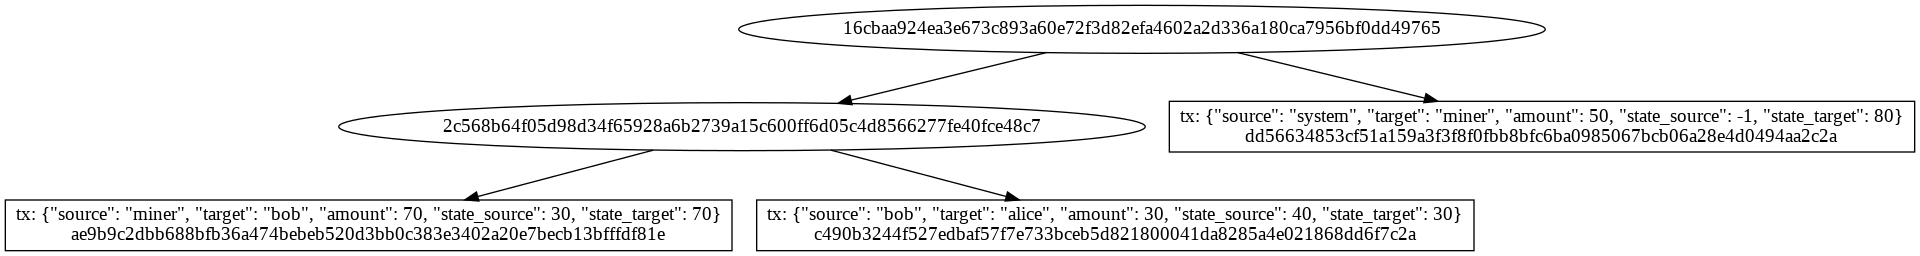

In [12]:
block1['merkle_tree'].print()
block1['merkle_tree'].show()

---